In [156]:
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import os
import re

from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

from keras.applications.vgg16 import VGG16 
from keras.models import Model

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

import pickle
import seaborn as sns

In [157]:
feature_matrix = pd.read_csv('data/feature_matrix.csv', index_col='id')

In [158]:
song_label = pd.read_csv('data/song_label.csv', index_col='id')

### Transform audio to image

In [171]:
# Load the audio file
AUDIO_FILE = 'test/Elton_John_Your_Song_Ringtone_(by Fringster.com).mp3'
samples, sample_rate = librosa.load(AUDIO_FILE, sr=None)

/Users/shoheisuzuki/miniforge3/envs/music-recommendation/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [160]:
Audio(AUDIO_FILE)

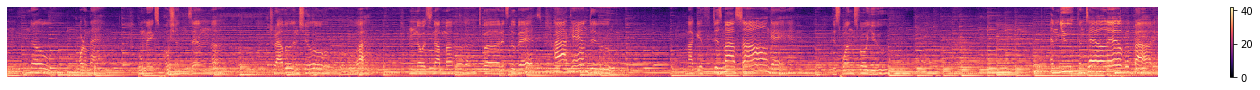

In [161]:
# Short-time Fourier transform
sgram = librosa.stft(samples)
# librosa.display.specshow(sgram)
magnitude, phase = librosa.magphase(sgram)
mel_scale_sgram = librosa.feature.melspectrogram(S=magnitude, sr=sample_rate, n_mels=128, fmax=8000)

# mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
mel_sgram = librosa.power_to_db(mel_scale_sgram, ref=np.min)

# Image size
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = float(mel_sgram.shape[1]) / float(100)
fig_size[1] = float(mel_sgram.shape[0]) / float(100)
plt.rcParams['figure.figsize'] = fig_size
plt.axis('off')
# plt.axes([0., 0., 1., 1.0], frameon=False, xticks=[], yticks=[])

librosa.display.specshow(mel_sgram, sr=sample_rate, x_axis='time', y_axis='hz')
plt.savefig('test/'+'test'+'.png', bbox_inches=None, pad_inches=0)
plt.colorbar()

### Extract features form image file

In [162]:
# load the model first and pass as an argument
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

### Load PCA model

In [163]:
pca_load = pickle.load(open('model/pca.pkl','rb'))

### Create PCA components from test image

In [164]:
pca_components = pca_load.transform(extract_features('test/test.png', model))

2022-03-09 12:32:45.277020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [165]:
pca_components = pd.DataFrame(pca_components, columns=['PC{}'.format(x + 1) for x in range(888)])

In [166]:
pca_components

PC1       PC2       PC3     PC4       PC5       PC6       PC7  \
0 -1.930774 -8.886889  5.979382  4.5527 -2.006494 -2.901917 -1.179383   

        PC8       PC9      PC10  ...     PC879     PC880     PC881     PC882  \
0 -6.640749  3.367842 -2.329495  ... -0.039494  0.023663 -0.020678 -0.085118   

     PC883     PC884     PC885     PC886     PC887     PC888  
0  0.12063 -0.072911  0.099367  0.029446 -0.225953 -0.097388  

[1 rows x 888 columns]

### Fit k-nearest neighbors to dataset

In [167]:
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(feature_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

### Find k-nearest neighbors of test data

In [168]:
distances, indices = model_knn.kneighbors(pca_components, n_neighbors = 20)

### Result

In [169]:
for i in range(0, len(distances.flatten())):
    id = feature_matrix.index[indices.flatten()[i]]
    labels = song_label.query('index==@id').to_numpy()
    print('{0}: {1} {2}, with distance of {3}:'.format(i, id, labels, distances.flatten()[i])) 

0: 150062 [[1 'Finn Anderson' "When He's Away" 'Folk']], with distance of 0.32379558133910236:
1: 42135 [[1 'Colin Shaddick & Roger Nicholls' 'E Boogie' 'Experimental']], with distance of 0.3442198676712691:
2: 37131 [[15 'Pharmacom' "Dracular's Revenge" 'Electronic']], with distance of 0.36424654137347057:
3: 49842 [[1 'My Bubba & Mi' 'Apple spell' 'Folk']], with distance of 0.3697530996677547:
4: 210 [[5 'Ed Askew' 'In the French Court' 'Folk']], with distance of 0.37164677944054225:
5: 134486 [[1 'Squire Tuck' 'Love&Heartbreak' 'Pop']], with distance of 0.3836445839090785:
6: 138318 [[5 'Big White' 'Whatever Happens In The Night' 'Rock']], with distance of 0.39129725483373423:
7: 190 [[1 'Ed Askew' 'Castle Of Stars' 'Folk']], with distance of 0.3935933303308504:
8: 105715 [[1 'Sam Moss' 'Neighbors' 'Folk']], with distance of 0.40466659050569265:
9: 138064 [[5 'Black Flamingo' 'Down' 'Pop']], with distance of 0.40568923913889454:
10: 107249 [[31 'Vanya Zhuk' 'Vodka' 'International']]

In [170]:
recommendation_1 = 'fma_small/150/150062.mp3'

In [139]:
Audio(recommendation_1)

In [131]:
recommendation_2 = 'fma_small/042/042135.mp3'

In [132]:
Audio(recommendation_2)

In [133]:
recommendation_3 = 'fma_small/037/037131.mp3'

In [134]:
Audio(recommendation_3)

In [135]:
recommendation_4 = 'fma_small/049/049842.mp3'

In [136]:
Audio(recommendation_4)

In [154]:
recommendation_5 = 'fma_small/134/134486.mp3'

In [155]:
Audio(recommendation_5)

In [137]:
Audio(AUDIO_FILE)